In [9]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
# from tensorflow.image import resize
from skimage.transform import resize
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize



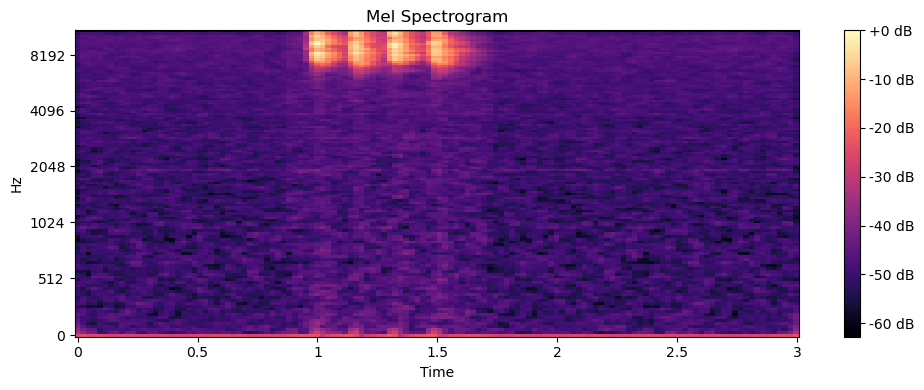

In [5]:
#preprocessing spectrum

In [10]:
data = np.load(r'C:\Users\weihua\Desktop\ADM\project2\mel_spectrograms\21038\iNat65519_chirp.npy')
# 
print(data)
#
print(data.shape)
print(data.dtype)

[[150 144 141 ... 142 140 143]
 [152 142 127 ... 111  54  75]
 [153 149 141 ... 102  74  63]
 ...
 [136 131 127 ... 123 117 109]
 [117 116 107 ... 108 106  90]
 [ 62  56  53 ...  55  51  51]]
(128, 64)
uint8


In [10]:
# hyperparameters
data_dir = 'mel_spectrograms'
csv_path = 'taxonomy.csv'
target_shape = (128, 128)

# loading metadata
metadata = pd.read_csv(csv_path)

# encode class_name to numerical label
le = LabelEncoder()
metadata['label'] = le.fit_transform(metadata['class_name'])  # 0,1

# map primary_label -> label
label_mapping = dict(zip(metadata['primary_label'].astype(str), metadata['label']))

# load and preprocess data
def load_and_preprocess_data(data_dir, label_mapping, target_shape=(128, 128)):
    data = []
    labels = []
    
    for folder_name in os.listdir(data_dir):
        if folder_name in label_mapping:
            folder_path = os.path.join(data_dir, folder_name)
            for filename in os.listdir(folder_path):
                if filename.endswith('.npy'):
                    file_path = os.path.join(folder_path, filename)
                    spectrogram = np.load(file_path)

                    # conclude resize and add channel dimentionality if necessary
                    spectrogram = resize(spectrogram, target_shape, mode='reflect', anti_aliasing=True)
                    spectrogram = np.expand_dims(spectrogram, axis=-1)

                    data.append(spectrogram)
                    labels.append(label_mapping[folder_name])
    
    return np.array(data), np.array(labels)

# load data, labels
data, labels = load_and_preprocess_data(data_dir, label_mapping, target_shape)

# One-hot encoding
labels = to_categorical(labels, num_classes=len(le.classes_))

# training and testing spliting
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [11]:

# model architecture
input_shape = X_train[0].shape
input_layer = Input(shape=input_shape)
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(64, activation='relu')(x)
output_layer = Dense(len(le.classes_), activation='softmax')(x)

model = Model(input_layer, output_layer)

# compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# training and assign to history
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=32)


Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 88ms/step - accuracy: 0.5693 - loss: 1.2182 - val_accuracy: 0.6385 - val_loss: 0.8807
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 89ms/step - accuracy: 0.6435 - loss: 0.8651 - val_accuracy: 0.7337 - val_loss: 0.7140
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.7376 - loss: 0.6685 - val_accuracy: 0.7687 - val_loss: 0.6284
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - accuracy: 0.8037 - loss: 0.5334 - val_accuracy: 0.8047 - val_loss: 0.5335
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 97ms/step - accuracy: 0.8510 - loss: 0.3978 - val_accuracy: 0.8309 - val_loss: 0.4888
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 13s 100ms/step - accuracy: 0.9027 - loss: 0.2705 - val_accuracy: 0.8659 - val_loss: 0.4081
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9586 - loss: 0.1434 - val_accuracy: 0.8552 - val_loss: 0.4406
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - accuracy: 0.9733 - loss: 0.1030 -

In [14]:
# check class labels
print(le.classes_)

# model predict
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)

['Amphibia' 'Aves' 'Insecta' 'Mammalia']
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step


In [19]:
#evaluate
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np

def evaluate_model(model, history, X_test, y_test, le):
    # 1. Plot train and validate accuracy / loss curve
    plt.figure(figsize=(12, 5))

    # Accuracy curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Loss curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.tight_layout()
    plt.show()

    # 2️.model predict for report
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 3️ output classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=le.classes_))

    # 4️ Plot Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

    # 5️ ROC Curve (multi_classfication one-vs-rest)
    y_test_bin = y_test  # one-hot style

    plt.figure(figsize=(8, 6))

    for i, class_name in enumerate(le.classes_):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC Curve (One-vs-Rest)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


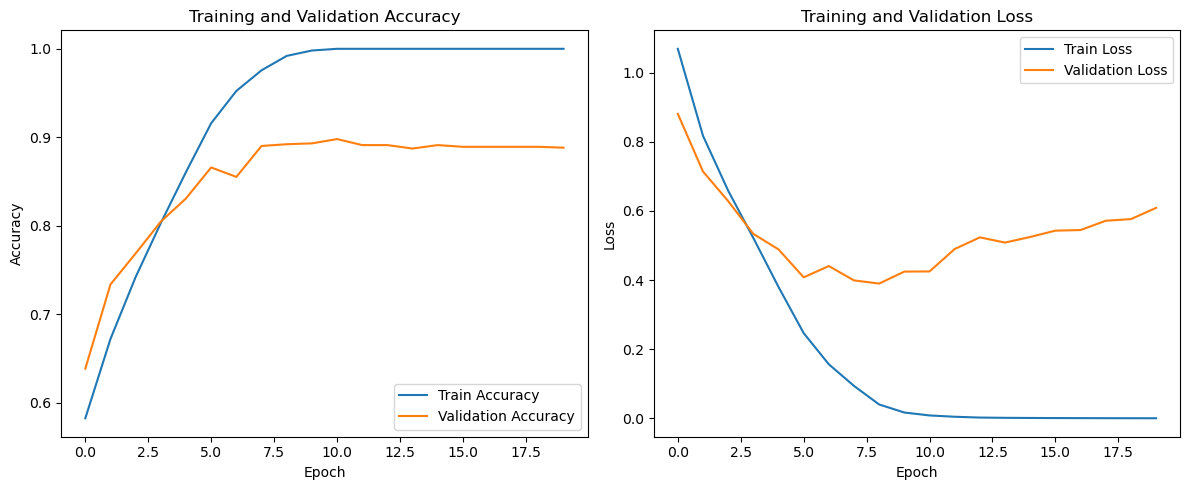

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step

Classification Report:
              precision    recall  f1-score   support

    Amphibia       0.91      0.95      0.93       593
        Aves       0.83      0.69      0.75       110
     Insecta       0.90      0.87      0.88       150
    Mammalia       0.84      0.82      0.83       176

    accuracy                           0.89      1029
   macro avg       0.87      0.83      0.85      1029
weighted avg       0.89      0.89      0.89      1029



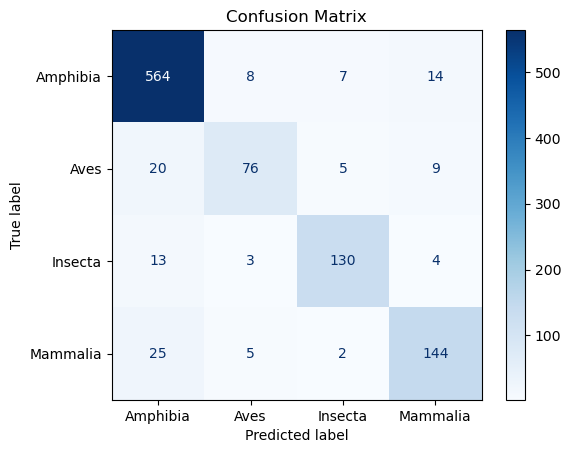

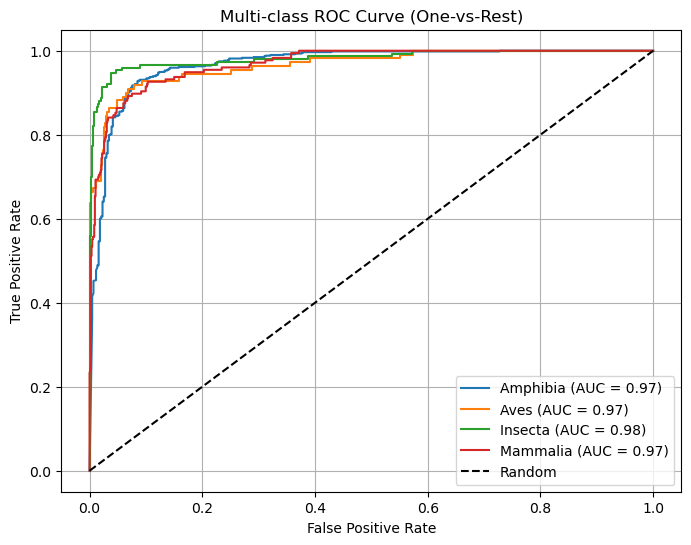

In [20]:
evaluate_model(model, history, X_test, y_test, le)

In [ ]:
#model save
model.save('animal_classifier.h5')